## Using Histogram of Gradients (HOG) to detect vehicles in videos


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 23 23:17:00 2017
Initial upload Mon Oct 31
Detects vehicles in a video and draws bounding boxes. Outputs video.
Detect and draw lanes

@author: Henry Yau
"""
# imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier

#see if we can benefit from TF 
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Lambda, Flatten, Dense, Conv2D, Dropout, Cropping2D, BatchNormalization, Activation
from sklearn.model_selection import train_test_split


#Helper functions for creating features
from hog_helper_optimize import *

#Pickle the model and parameters once it is learned
import pickle
train_SVC_b = False
train_Keras_b = False


Using TensorFlow backend.


In [2]:

if train_SVC_b == True or train_Keras_b == True:
    """Perform feature extraction and training"""
    # Read in car and non-car images
    cars = glob.glob('./data/vehicles/**/*.png')
    notcars = glob.glob('./data/non-vehicles/**/*.png')

    spatial = 8
    histbin = 8

    #Number of orientation bins.
    orient = 8
    #Size (in pixels) of a cell.
    pix_per_cell = 8

    #Number of cells in each block.
    #cells_per_block : 2-tuple (int, int), optional
    cell_per_block = 3

    print('Extracting car feature')
    car_features = extract_features_augmented(cars, cspace='YCrCb', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
    print('Extracting non-car feature')
    notcar_features = extract_features_augmented(notcars, cspace='YCrCb', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

    print('Scaling feature vector')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    print('Labeling and splitting train/test data')
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

#     print('Using ', spatial, ' spatial bins and', histbin,' histogram bins')
    print('HOG using ', orient,' orientation bins with ', pix_per_cell,'^2 pixels per cell and ', cell_per_block, '^2 cells per block')

    print('Feature vector length:', len(X_train[0]))


In [3]:
if train_Keras_b == True:
    clf = Sequential()    
   
    clf.add(Dense(32,input_shape=(len(X_train[0]),)))
    clf.add(Activation('relu'))
    clf.add(Dropout(0.5))    
    
    clf.add(Dense(10, activation='sigmoid'))
    clf.add(Dropout(0.5)) 
    clf.add(Dense(8, activation='sigmoid'))
    clf.add(Dropout(0.5))
    clf.add(Dense(1, activation='sigmoid')) # just get yes no    
    
    clf.compile(loss='binary_crossentropy', optimizer = 'adam',metrics=['accuracy'])

    clf.fit(X_train, y_train, epochs=8, batch_size=96)  
    
    
    clf.save('./models/model.h5')
    
    t=time.time()
    print('Test Accuracy of Classifier = ', clf.evaluate(X_test, y_test))
    print(clf.predict(X_test[0:10]))
    print((y_test[0:10]))
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', len(X_test),'labels with classifier')

else:
    clf = load_model('./models/model.h5')
    

In [4]:
# if train_SVC_b == True:
#     # Check the score of the Classifier  
#     t=time.time()
#     print('Test Accuracy of Classifier = ', round(clf.score(X_test, y_test), 4))
#     clf.predict(X_test)
#     t2 = time.time()
#     print(round(t2-t, 5), 'Seconds to predict', len(X_test),'labels with classifier')

#Save things in a Pickle
if train_Keras_b == True:
    data_pickle = {
#         'svc': svc,
        'scaler': X_scaler,
        'orient': orient,
        'pix_per_cell': pix_per_cell,
        'cell_per_block': cell_per_block,
        'spatial_size': spatial,
        'hist_bins': histbin
    }
    with open('CLF_data_augmented.p', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data_pickle, f, pickle.HIGHEST_PROTOCOL)

#     dist_pickle = pickle.load( open("CLF_data_augmented.p", "rb" ) )
# #     clf = dist_pickle["classifier"] # use TF instead
#     X_scaler = dist_pickle["scaler"]
#     orient = dist_pickle["orient"]
#     pix_per_cell = dist_pickle["pix_per_cell"]
#     cell_per_block = dist_pickle["cell_per_block"]
#     spatial = dist_pickle["spatial_size"]
#     histbin = dist_pickle["hist_bins"]
    
if train_Keras_b == False:
    #load pickled data
    dist_pickle = pickle.load( open("CLF_data_augmented.p", "rb" ) )

#     svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial = dist_pickle["spatial_size"]
    histbin = dist_pickle["hist_bins"]


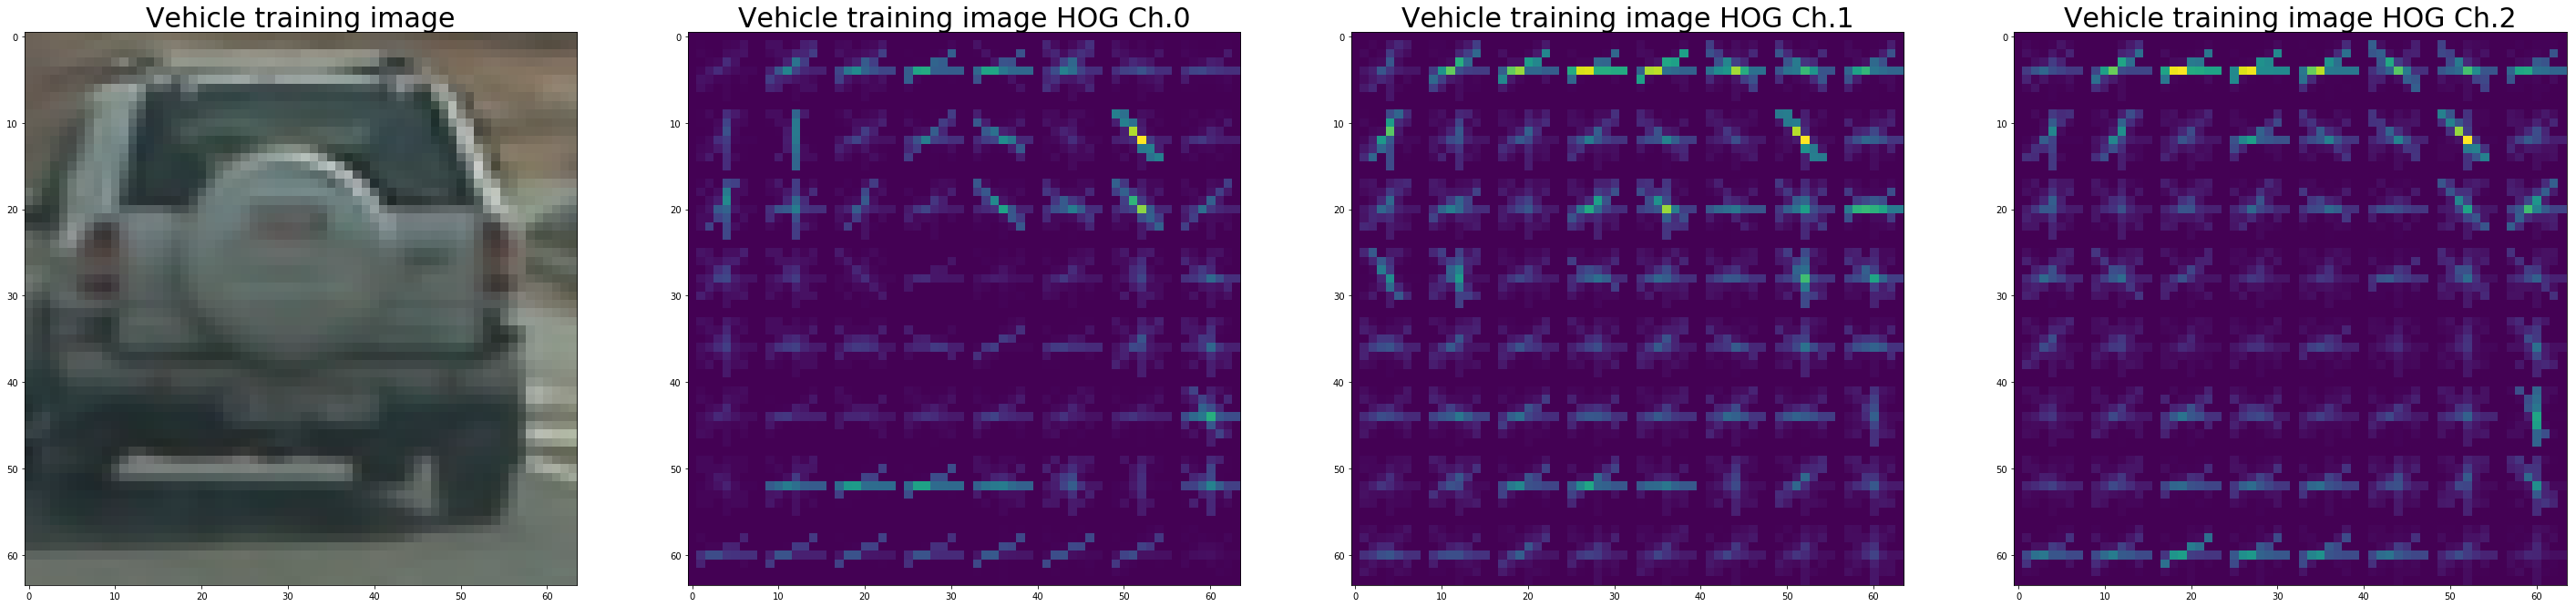

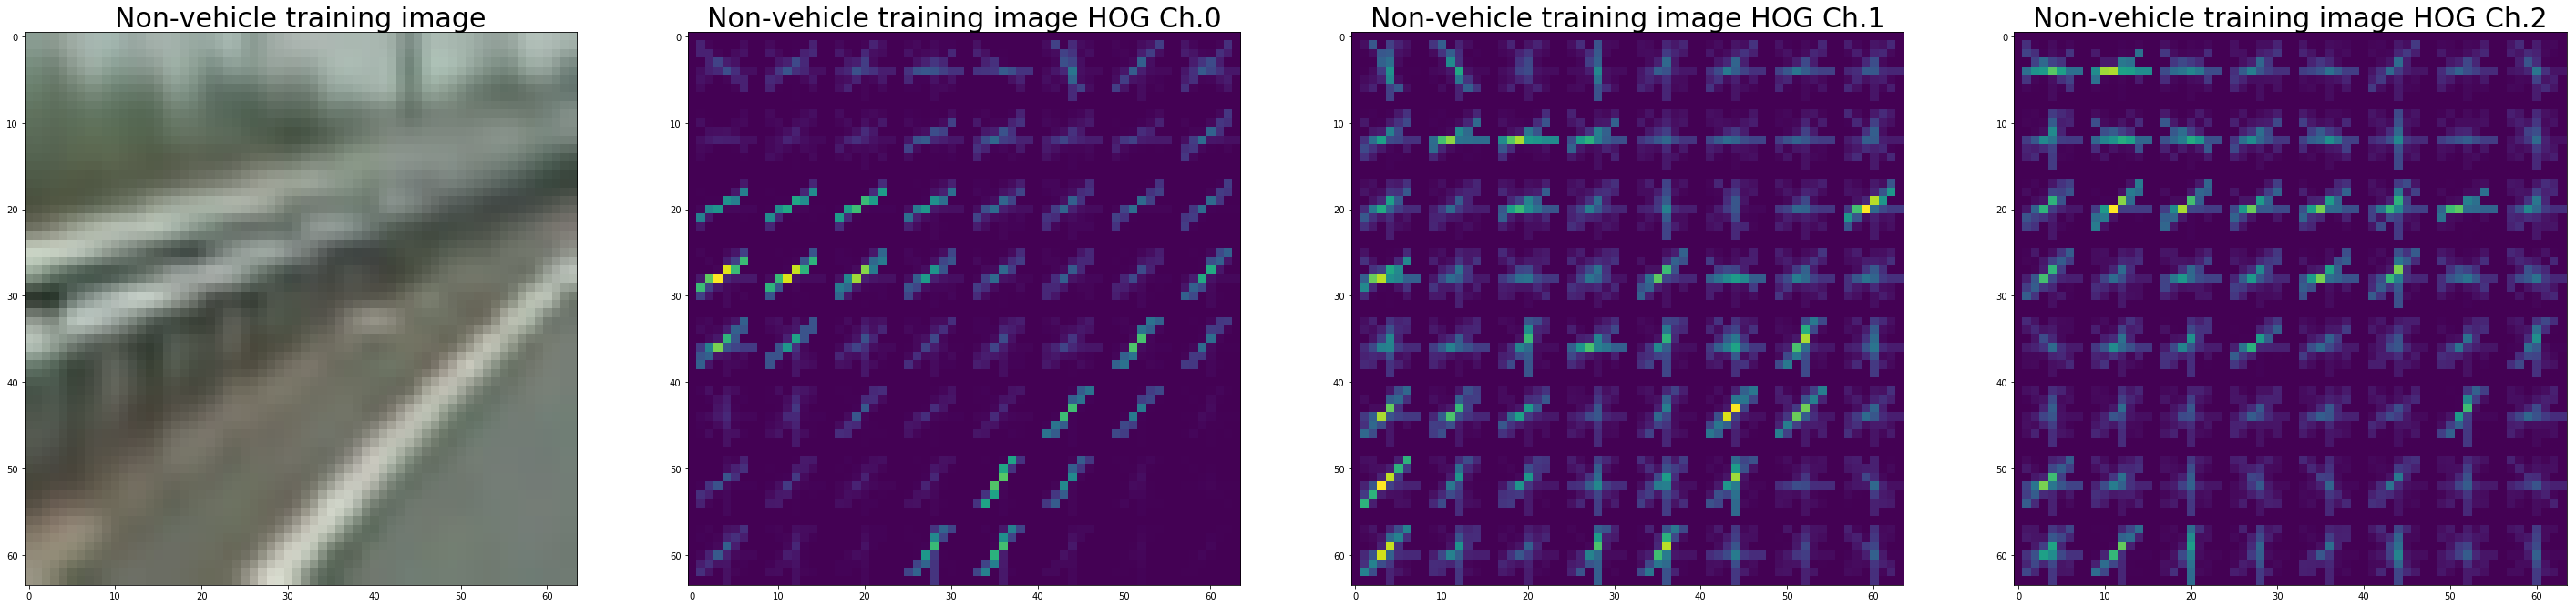

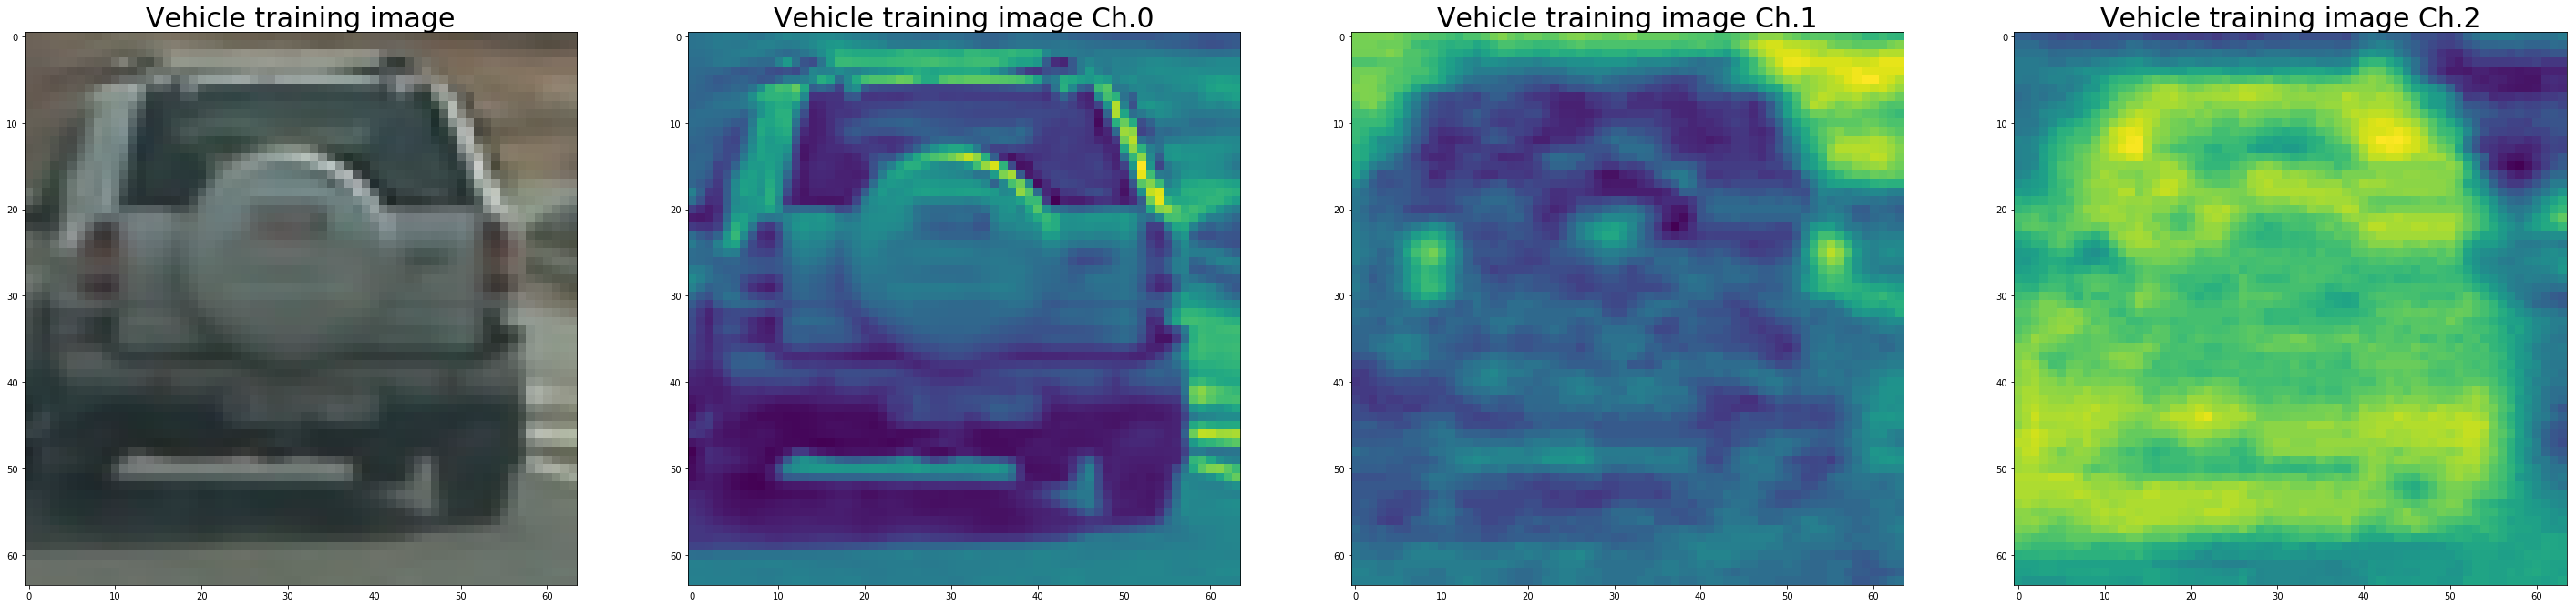

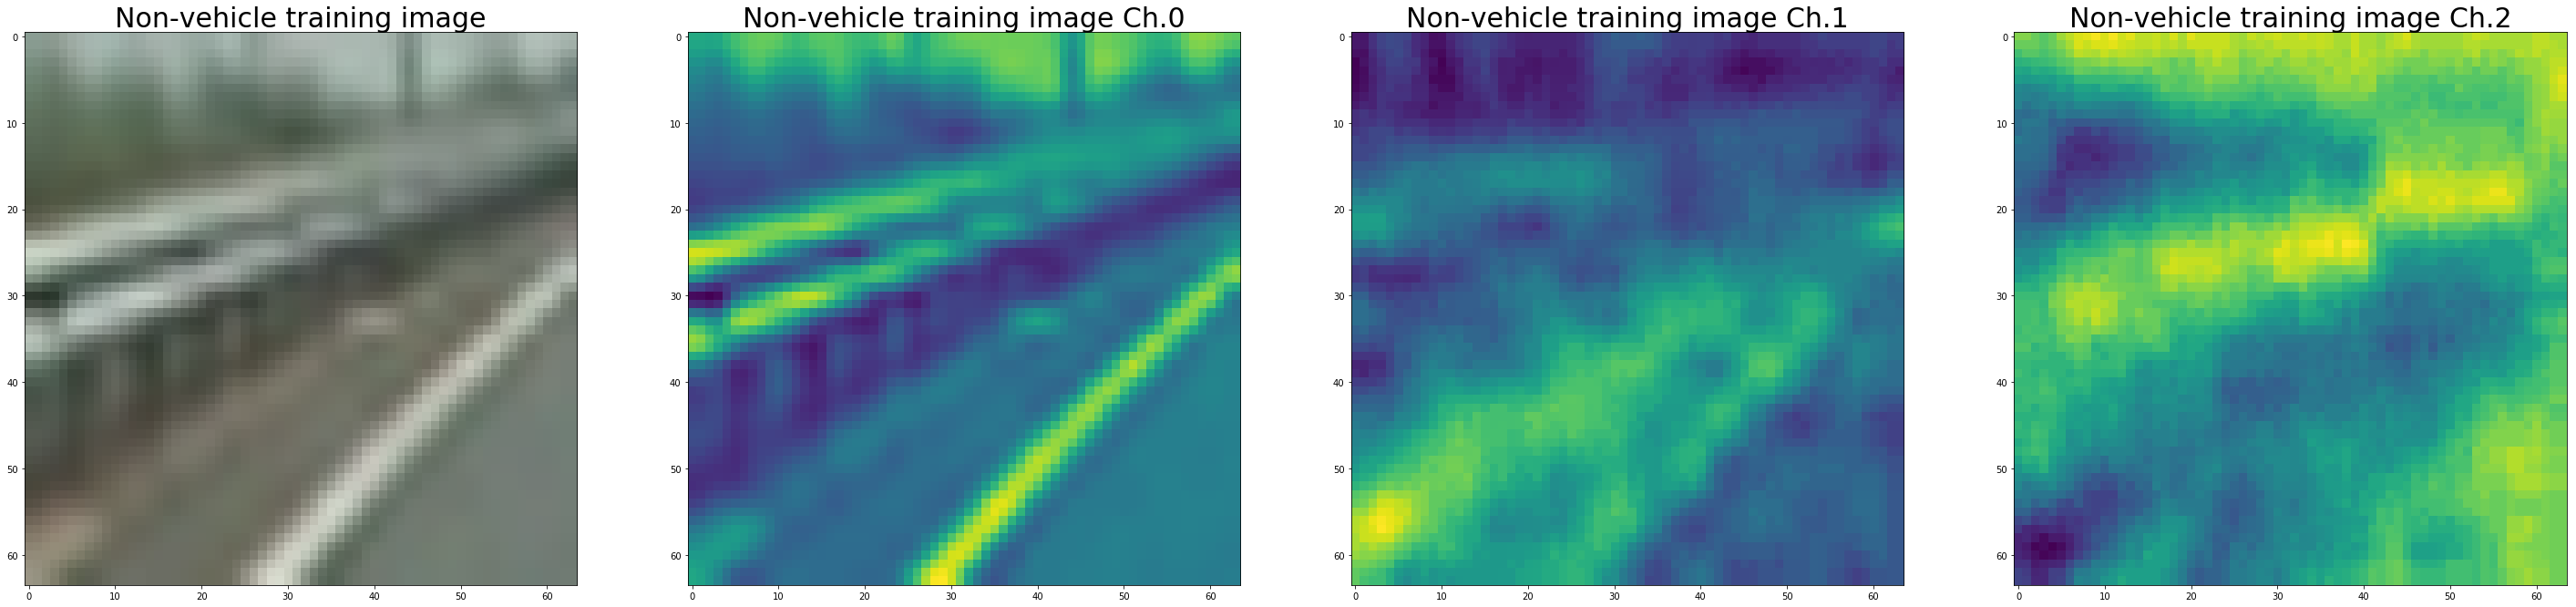

In [5]:
#demonstrate the HOG 
#generate a few images for readme
car_test_img = mpimg.imread('./data/vehicles/GTI_MiddleClose/image0066.png')
notcar_test_img =  mpimg.imread('./data/non-vehicles/GTI/image8.png')

car_test_img_YCrCb = convert_color(car_test_img, conv='RGB2YCrCb')
notcar_test_img_YCrCb = convert_color(notcar_test_img, conv='RGB2YCrCb')

hog_test, hog_testv0_img = get_hog_features(car_test_img_YCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testv1_img = get_hog_features(car_test_img_YCrCb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testv2_img = get_hog_features(car_test_img_YCrCb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)

hog_test, hog_testnv0_img = get_hog_features(notcar_test_img_YCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testnv1_img = get_hog_features(notcar_test_img_YCrCb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)
hog_test, hog_testnv2_img = get_hog_features(notcar_test_img_YCrCb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True,feature_vec=False)


#plot car and hog, and maybe the other features

plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(car_test_img)
plt.title('Vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(hog_testv0_img)
plt.title('Vehicle training image HOG Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(hog_testv1_img)
plt.title('Vehicle training image HOG Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(hog_testv2_img)
plt.title('Vehicle training image HOG Ch.2',fontsize=30)
plt.show()


plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(notcar_test_img)
plt.title('Non-vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(hog_testnv0_img)
plt.title('Non-vehicle training image HOG Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(hog_testnv1_img)
plt.title('Non-vehicle training image HOG Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(hog_testnv2_img)
plt.title('Non-vehicle training image HOG Ch.2',fontsize=30)
plt.show()


plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(car_test_img)
plt.title('Vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(car_test_img_YCrCb[:,:,0])
plt.title('Vehicle training image Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(car_test_img_YCrCb[:,:,1])
plt.title('Vehicle training image Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(car_test_img_YCrCb[:,:,2])
plt.title('Vehicle training image Ch.2',fontsize=30)
plt.show()

plt.figure(figsize = (50,50))

plt.subplot(1, 4, 1)
plt.imshow(notcar_test_img)
plt.title('Non-vehicle training image',fontsize=30)
plt.subplot(1, 4, 2)
plt.imshow(notcar_test_img_YCrCb[:,:,0])
plt.title('Non-vehicle training image Ch.0',fontsize=30)
plt.subplot(1, 4, 3)
plt.imshow(notcar_test_img_YCrCb[:,:,1])
plt.title('Non-vehicle training image Ch.1',fontsize=30)
plt.subplot(1, 4, 4)
plt.imshow(notcar_test_img_YCrCb[:,:,2])
plt.title('Non-vehicle training image Ch.2',fontsize=30)
plt.show()

In [6]:
#%%
spatial_size = (spatial, spatial)
hist_bins = histbin

def find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, output_img_b = True, cells_per_step = 1.0):
    """Finds vehicles in image using a sliding moving window.
    if output_img_b == True, output image with the original image with bounding box as well as a heatmap 
    else return just the heatmap
    """  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255 # not sure why this was in here... it is normalized by X_scaler
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
#     ch2 = ctrans_tosearch[:,:,1]
#     ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    
    #also search with different window sizes
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 32
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    nxsteps = int((nxblocks - nblocks_per_window) // cells_per_step)+1
    nysteps = int((nyblocks - nblocks_per_window) // cells_per_step)+1
    
    
    box_list = []
    
    # Compute Y-channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            # Extract the image patch
            ypos = int(yb*cells_per_step)
            xpos = int(xb*cells_per_step)
            xleft = int(xpos*pix_per_cell)
            ytop = int(ypos*pix_per_cell)
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
       
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

#             hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            hog_features = np.hstack((hog_feat1))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
#             test_features = np.hstack((hog_features)).reshape(1, -1) 
            test_features = np.hstack((spatial_features,hist_features, hog_features)).reshape(1, -1) 
            test_features = X_scaler.transform(test_features)
            test_prediction = (clf.predict(test_features))
#             print(test_prediction)    
            
            if test_prediction >0.4:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if output_img_b == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                box_list.append(np.array([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]))
    
    
    heatmap_img = np.zeros_like(draw_img[:,:,0])
    add_heat(heatmap_img, box_list)
    if output_img_b == True:
        return draw_img, heatmap_img
    else:
        return heatmap_img
    #return draw_img, hog1_img, hog2_img, hog3_img
    


1.65 Seconds to classify.


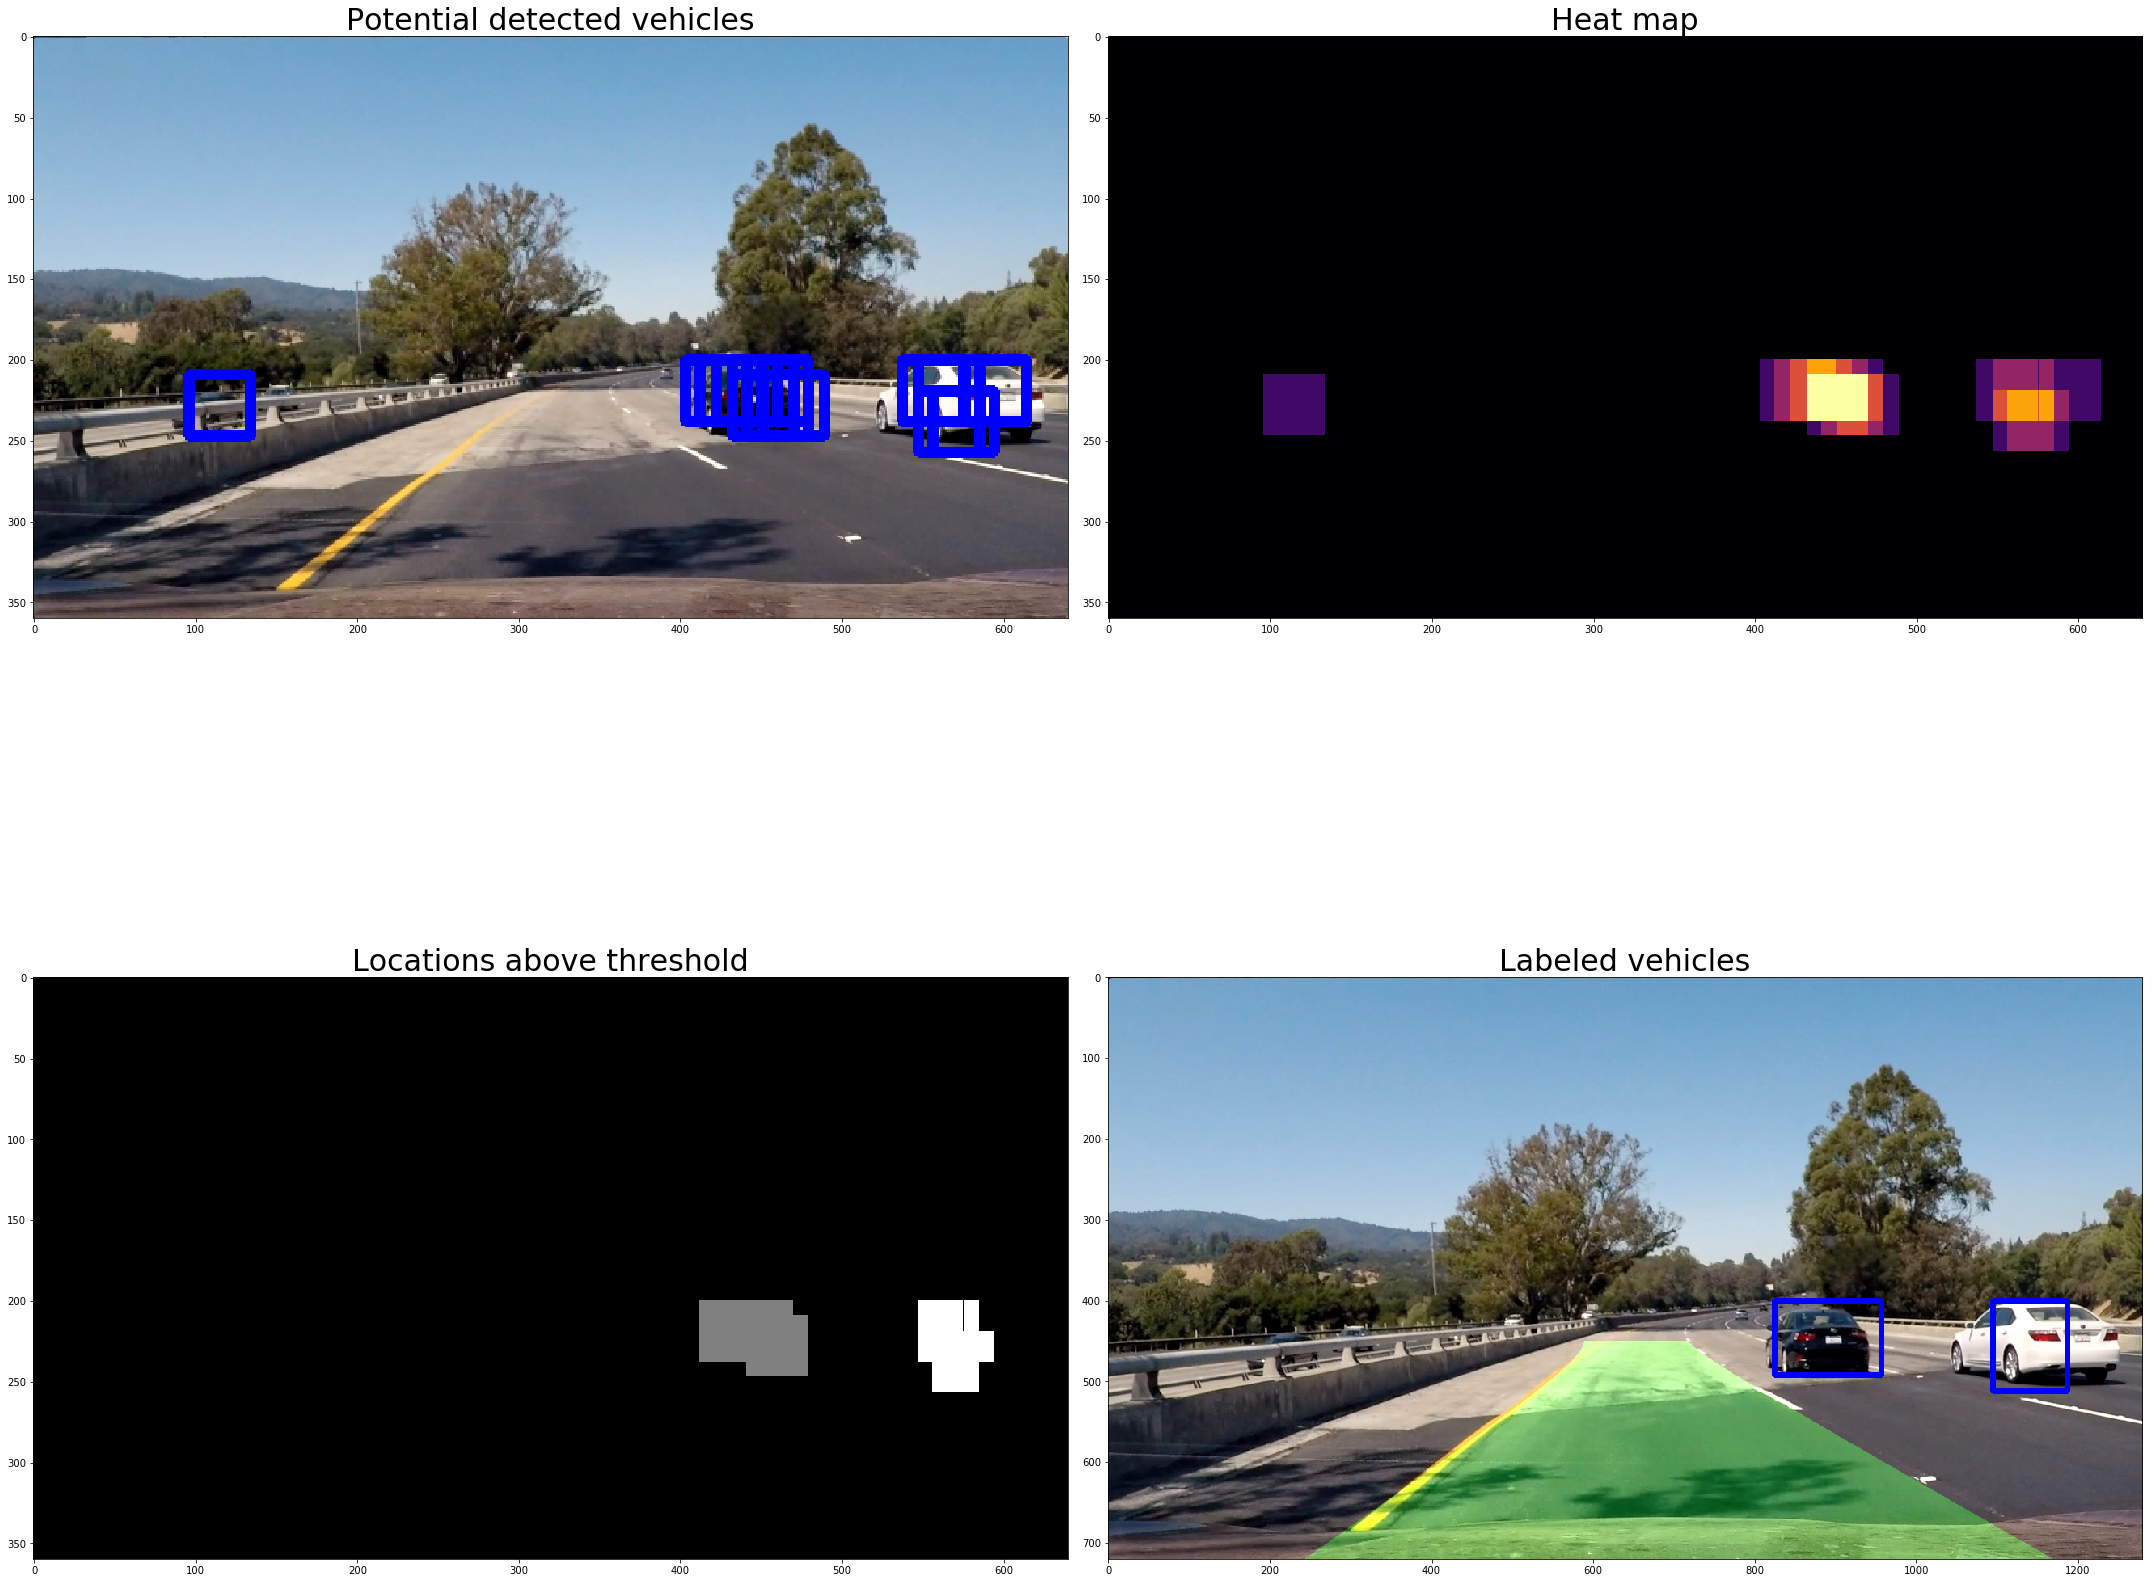

2 cars found


In [7]:
# Test the find_cars() function and create images for writeup
ystart = 400
ystop = 700
import lane_overlay
from scipy.ndimage.measurements import label

#lane detection 
objpoints, imgpoints = lane_overlay.calibrate_camera()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)
M, Minv, ctr_pt, warp_ratio = lane_overlay.perspectiveWarp()
        
left_line = lane_overlay.Line()    
right_line = lane_overlay.Line()
font = cv2.FONT_HERSHEY_SIMPLEX

    
img = mpimg.imread('./data/test_images/test4.jpg')
t=time.time()

scale_img = 2

# out_img1, heat_img1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


img_small = cv2.resize(img,None, fx=1/scale_img, fy=1/scale_img, interpolation = cv2.INTER_LINEAR)


# out_img1, heat_img1 = find_cars(img_small, ystart//scale_img, ystop//scale_img, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
scale = 1.2
use_tf_b = True

if use_tf_b == True:
    out_img1, heat_img1 = find_cars(img_small, int(ystart//scale_img), int(ystop//scale_img), scale, clf, X_scaler, \
                     orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step = 1)

else:
    out_img1, heat_img1 = find_cars(img_small, int(ystart//scale_img), int(ystop//scale_img), scale, svc, X_scaler, \
                     orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step = 1)

# scale = 4
# out_img2, heat_img2 = find_cars(img_small, int(ystart//scale_img), int(ystop//scale_img), scale, clf, X_scaler, \
#                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step = 2)

heat_img = heat_img1#+heat_img2#+heat_img3
threshold_val = 1


t2 = time.time()
print(round(t2-t, 2), 'Seconds to classify.')


plt.figure(figsize = (30,30))
plt.subplot(2, 2, 1)
plt.title('Potential detected vehicles',fontsize=30)
plt.imshow(out_img1)

plt.subplot(2, 2, 2)
plt.imshow(heat_img, cmap='inferno', vmin=0, vmax=5)
plt.title('Heat map',fontsize=30)

heat_thresh_img = apply_threshold(heat_img, threshold_val)
labels = label(heat_thresh_img)

img_lane = lane_overlay.process_lane_overlay(img,objpoints, imgpoints, mtx, dist, M,Minv, left_line, right_line,warp_ratio,ctr_pt)
img_labeled = draw_labeled_bboxes(img_lane, labels, scale_img)


plt.subplot(2, 2, 3)
plt.imshow(labels[0], cmap='gray')
plt.title('Locations above threshold',fontsize=30)

plt.subplot(2, 2, 4)
plt.imshow(img_labeled)
plt.title('Labeled vehicles',fontsize=30)

plt.tight_layout()
plt.show()

print(labels[1], 'cars found')

In [8]:
global heat_img_array
heat_img_array = []

global frame_cnt
frame_cnt = 0
global labels

def process_vehicle_overlay(img):
    """Processes a single frame from video. Uses the same sliding window search as above
    however also uses a buffer of past heatmaps to mitigate potential false positives"""
    global frame_cnt
    global labels

    scale_img = 2
    if frame_cnt%8 == 0 or frame_cnt == 0:
     
        img_small = cv2.resize(img,None, fx=1/scale_img, fy=1/scale_img, interpolation = cv2.INTER_LINEAR)
        scale = 1.2
        heat_img1 = find_cars(img_small, ystart//scale_img, ystop//scale_img, scale, clf,\
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False,cells_per_step = 1)
#         scale = 2
#         heat_img2 = find_cars(img_small, ystart//scale_img, ystop//scale_img, scale, clf,\
#                               X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False,cells_per_step = 2)

#         scale = 4
#         heat_img2 = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)

        heat_img = heat_img1#+heat_img2#+heat_img3

        global heat_img_array

        heat_img_array.append(heat_img)
        if(len(heat_img_array)>4):
            heat_img_array = heat_img_array[1:-1]

        heat_img = sum(heat_img_array)

        threshold_val =3
        heat_thresh_img = apply_threshold(heat_img, threshold_val)
        labels = label(heat_thresh_img)

        img_lane = lane_overlay.process_lane_overlay(img,objpoints, imgpoints, mtx, dist, M,Minv, left_line, right_line,warp_ratio,ctr_pt)
    else:
        #if skipped lane detection, just draw old stuff. speed up
        img_lane = lane_overlay.draw_overlay_LR(img, left_line.bestx, right_line.bestx, Minv) 
    img_labeled = draw_labeled_bboxes(img_lane, labels,scale_img)
    
#     img_labeled = draw_labeled_bboxes(img, labels, 1)
        
    frame_cnt+=1
    return img_labeled


In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


video_unprocessed = VideoFileClip("./data/test_videos/project_video.mp4").subclip(25,50)
video_processed = video_unprocessed.fl_image(process_vehicle_overlay) 

video_output = './output_videos/project_video_output_w_lane_test3.mp4'
# video_output = './output_videos/harder_challenge_video_augmented.mp4'
%time video_processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))




MoviePy: building video file ./output_videos/project_video_output_w_lane_test3.mp4
----------------------------------------

Writing video into ./output_videos/project_video_output_w_lane_test3.mp4


100%|███████████████████████████████████████▉| 600/601 [04:05<00:00,  2.44it/s]


Done writing video in ./output_videos/project_video_output_w_lane_test3.mp4 !
Your video is ready !
Wall time: 4min 6s
